In [ ]:
from google.colab import auth
auth.authenticate_user()

from google.colab import drive
drive.mount('/content/gdrive', force_remount=False)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
import os
from pathlib import Path

# folder 변수에 구글드라이브에 프로젝트를 저장한 디렉토리를 입력하세요!
folder = ""
project_dir = "01_dnn_pt"

base_path = Path("/content/gdrive/My Drive/")
project_path = base_path / folder / project_dir
os.chdir(project_path)
for x in list(project_path.glob("*")):
    if x.is_dir():
        dir_name = str(x.relative_to(project_path))
        os.rename(dir_name, dir_name.split(" ", 1)[0])
print(f"현재 디렉토리 위치: {os.getcwd()}")

현재 디렉토리 위치: /content/gdrive/My Drive/01_dnn_pt


In [ ]:
## 첫번째 코드블록
import torch 
print('pytorch version: {}'.format(torch.__version__))

pytorch version: 1.5.1+cu101


## 1. Package load

In [ ]:
import torch
import torch.nn as nn
import torchvision.datasets as dset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import check_util.checker as checker 
%matplotlib inline

print('pytorch version: {}'.format(torch.__version__))
print('GPU 사용 가능 여부: {}'.format(torch.cuda.is_available()))
device = "cuda" if torch.cuda.is_available() else "cpu"   # GPU 사용 가능 여부에 따라 device 정보 저장

pytorch version: 1.5.1+cu101
GPU 사용 가능 여부: True


## 2. 하이퍼파라미터 세팅

In [ ]:
batch_size = 100
num_epochs = 5
learning_rate = 0.001

## 3. Dataset 및 DataLoader 할당

In [ ]:
from torch.utils.data import DataLoader

root = './data'
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=(0.5,), std=(0.5,))])
train_data = dset.FashionMNIST(root=root, train=True, transform=transform, download=True)
test_data = dset.FashionMNIST(root=root, train=False, transform=transform, download=True)

train_loader = DataLoader(train_data, batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size, shuffle=False)


## 4. 데이터 샘플 시각화


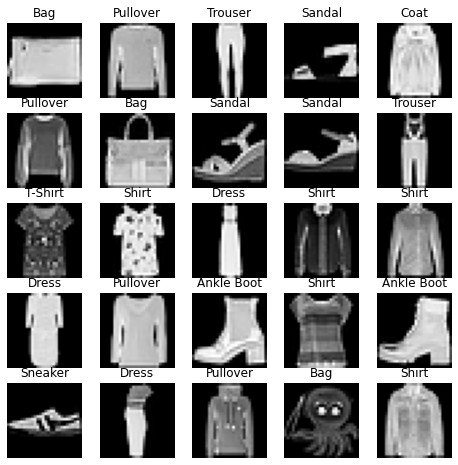

In [ ]:
labels_map = {0 : 'T-Shirt', 1 : 'Trouser', 2 : 'Pullover', 3 : 'Dress', 4 : 'Coat', 5 : 'Sandal', 6 : 'Shirt',
              7 : 'Sneaker', 8 : 'Bag', 9 : 'Ankle Boot'}
columns = 5
rows = 5
fig = plt.figure(figsize=(8,8))

for i in range(1, columns*rows+1):
    data_idx = np.random.randint(len(train_data))
    img = train_data[data_idx][0][0,:,:].numpy() # numpy()를 통해 torch Tensor를 numpy array로 변환
    label = labels_map[train_data[data_idx][1]] # item()을 통해 torch Tensor를 숫자로 변환
    
    fig.add_subplot(rows, columns, i)
    plt.title(label)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
plt.show()

## 5. 네트워크 설계


In [ ]:
class DNN(nn.Module):
    def __init__(self, num_classes=10):
        super(DNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(784, 512),  
            nn.BatchNorm1d(512),  
            nn.ReLU()     
        )
        self.layer2 = nn.Sequential(
            nn.Linear(512, 10)    
        )
    
    def forward(self, x):
        x = x.view(x.size(0), -1) # flatten
        x_out = self.layer1(x)
        x_out = self.layer2(x_out)
        return x_out

## 6. Weight initialization

In [ ]:
def weights_init(m):
    if isinstance(m, nn.Linear): # 모델의 모든 MLP 레이어에 대해서
        nn.init.xavier_normal_(m.weight) # Weight를 xavier_normal로 초기화
        print(m.weight)

## 7. 모델 생성

In [ ]:
torch.manual_seed(7777) # 일관된 weight initialization을 위한 random seed 설정
model = DNN().to(device)
model.apply(weights_init) # 모델에 weight_init 함수를 적용하여 weight를 초기화

## 8. Loss function 및 Optimizer 정의


In [ ]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## 9. Training


In [ ]:
for epoch in range(num_epochs):
    for i, (imgs, labels) in enumerate(train_loader):
        imgs, labels = imgs.to(device), labels.to(device)

        outputs = model(imgs) 
        loss = criterion(outputs, labels)   
        
        optimizer.zero_grad()           
        loss.backward()          
        optimizer.step() 
        
        _, argmax = torch.max(outputs, 1)
        accuracy = (labels == argmax).float().mean()
        
        if (i+1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'.format(
                epoch+1, num_epochs, i+1, len(train_loader), loss.item(), accuracy.item() * 100))

## 10. Test

In [ ]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for i, (imgs, labels) in enumerate(test_loader):
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, argmax = torch.max(outputs, 1) # max()를 통해 최종 출력이 가장 높은 class 선택
        total += imgs.size(0)
        correct += (labels == argmax).sum().item()
    
    print('Test accuracy for {} images: {:.2f}%'.format(total, correct / total * 100))

Test accuracy for 10000 images: 88.79%
